In [1]:
import sqlalchemy
import pandas as pd
from sqlalchemy import text
import os
from dotenv import load_dotenv
from pathlib import Path

import os

import prophet
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from prophet import Prophet
import ruptures as rpt
from ruptures.utils import pairwise
from itertools import cycle

from slack.web.client import WebClient
from slack.errors import SlackApiError



mpl.rcParams['figure.figsize'] = (20, 16)
mpl.rcParams['axes.grid'] = False


/Users/sabhinav/miniconda3/envs/anomaly/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
import sys, os

base_dir = os.path.join(os.getenv('HOME'), "idelic")
data_dir = os.path.join(base_dir, "data")
model_dir = os.path.join(base_dir, 'models')

sys.path.append(os.path.join(base_dir, "data-science/ds/data_science"))


In [3]:
#TODO: modify this for deployment env
dotenv_path = Path('./.env')
load_dotenv(dotenv_path=dotenv_path)

password = os.getenv('PASSWORD')
user = os.getenv('USER')
host = os.getenv('HOST')
database = os.getenv('DATABASE')
slack_token = os.getenv('SLACK_TOKEN')

In [4]:
engine = sqlalchemy.create_engine(f'postgresql://{user}:{password}@{host}/{database}')
client = WebClient(token=slack_token)


# def create_engine(*, from_env=False, url=None, 
#                   dialect='postgresql', user=None, password=None, 
#                   hostname=None, port=5432, database='datascience'):
#     if from_env:
#         url = os.getenv('DS_DB_URL', None)
        
#         if url is None:
#             dialect = os.getenv('DS_DB_DIALECT', dialect)
#             user = os.getenv('DS_DB_USER', user)
#             password = os.getenv('DS_DB_PASSWORD', password)
#             hostname = os.getenv('DS_DB_HOSTNAME', hostname)
#             port = os.getenv('DS_DB_PORT', port)
#             database = os.getenv('DS_DB_DATABASE', database)
    
#             assert hostname is not None, "Must set either DS_DB_URL or DS_DB_HOSTNAME in environment"
#     else:
#         assert bool(url) != bool(hostname), "Must pass exactly one of url, hostname"

#     if not url:
#         url = "{dialect}://{user}:{password}@{hostname}:{port}/{database}".format(
#                     dialect=dialect,
#                     user=user,
#                     password=password,
#                     hostname=hostname,
#                     port=port,
#                     database=database
#                 )
    
#     engine = sqlalchemy.create_engine(url)
#     return engine

In [5]:
from dataclasses import dataclass

@dataclass
class QueryMetadata:
    """Definition of a query.
    Return columns are (customer, date, value) and must be named ('customer', 'ds', 'y')
    Rows must be ordered by date within a customer
    """
    
    name : str
    query : str
    
    interpolate : bool = True
    ad_params : dict = None
    penalty_multiplier : float = 1.0


@dataclass
class AnomalyData:
    """Data for a single time series.
    """
    
    # extracted data
    customer : str
    series_name : str
    df : pd.DataFrame # data suitable for prophet: columns are (date, value) and have to be named (ds and y)
    
    # computed results
    P : float # total anomaly score for this series
    outliers : list # datapoints that are labeled as anomaly
    changepoints : list #indices that mark a change in data mean/variance
    extract_date : pd.Timestamp #
    # ad_params: dict[str, object] = None


In [6]:

class DataGenerator(object):
    def run(self):
        raise Exception("Not implemented on base class")

class DatadogDataGenerator(DataGenerator):
    pass

class AstronomerDataGenerator(DataGenerator):
    pass


class SQLDataGenerator(DataGenerator):
    def __init__(self, 
                 query_metadata : QueryMetadata, 
                 engine, 
                 extract_window : int = 90, 
                 min_length_to_keep : int = None):
        self.query_metadata = query_metadata
        self.extract_window = extract_window
        self.engine = engine
        self.min_length_to_keep = min_length_to_keep
        if self.min_length_to_keep is None:
            self.min_length_to_keep = int(self.extract_window * 0.75)
        # self.ad_params = ad_params
        # self.datetime_colname = datetime_colname #(ad_param)
        # self.y_colname = y_colname # (ad_param)
        # possibly add the test and train window lengths so we can filter out dfs with len < test+train window
        # return self

    def run(self):
        today = pd.Timestamp('today')
        
        with self.engine.connect() as con:
            # This data contains all customers
            output = []
            
            for query in self.query_metadata:
                sql = text(query.query)
                query_df = pd.read_sql_query(sql, con, params={'start_date':(today - pd.Timedelta(days=self.extract_window)).strftime("%Y-%m-%d"), 
                                                               'end_date':today.strftime("%Y-%m-%d")})

                customer_names = query_df.customer.unique()
                for cust in customer_names:
                    series_df = query_df.drop('customer', axis=1)[query_df.customer == cust]
                    series_df.ds = pd.to_datetime(series_df.ds)
                    series_df.reset_index(inplace=True, drop=True)
                    # the index of all these dfs needs to be reset because the train/test indices wont work otherwise
                    series_df = self._reindex_df(series_df, interpolate=query.interpolate)
                    
                    series_name = query.name
                    ad = AnomalyData(customer=cust, series_name=series_name, df=series_df, P=0, outliers=[], changepoints=[],
                                     extract_date=today)#, ad_params=query.ad_params)
                    
                    output.append(ad)

        # the output will contain certain customers who don't have enough data 
        # let's retain the dfs that have atleast entries over min length
        filtered_output = [i for i in output if self.min_length_to_keep <= 0 or len(i.df) >= self.min_length_to_keep]

        return filtered_output
    
    def _reindex_df(self, df_inp, *, interpolate=True):
        """Force series to have values for every day in range, interpolating missing values."""
        start_date = df_inp.ds.iloc[0] 
        end_date = df_inp.ds.iloc[-1]
        idx = pd.date_range(start_date, end_date)

        df = df_inp.set_index('ds')#,inplace=True)
        df = df.reindex(idx)
        ## preserve the orig y
        df['y_orig'] = df['y']
        if interpolate and len(df_inp) > 2:
            df['y']= df['y'].interpolate(method='linear')
        else:
            df['y']= df['y'].fillna(0)
        df = df.rename_axis('ds').reset_index()
        return df

In [7]:
class AnomalyDetector(object):
    def apply(self):
        raise Exception("Method not defined on abstract base class")

    def apply_changepnt_detection(self,changepnt_model="rbf"):
        '''
        Apply changepoint detection ala ruptures package and generate breakpoint indices
        Args
        ---
        changepoint_model: str
            Pelt segment model, ["l1", "l2", "rbf"] 
            https://centre-borelli.github.io/ruptures-docs/code-reference/detection/pelt-reference/

        Returns
        ---
        breakpoints: list
            List of breakpoint indices
        '''
        signal = self.data.df['y'].to_numpy()
        algo = rpt.Pelt(model=changepnt_model).fit(signal)
        result = algo.predict(pen=self.ruptures_changepnt_penalty)
        breakpoints = [1] + sorted(result)
        self.data.changepoints = breakpoints
        return self

    def plot_changepoints(self): 
        color_cycle = cycle(self.color_cycle)
        fig, ax = plt.subplots(1,1,figsize=(16,8))
        ax.plot(self.data.df['ds'],self.data.df['y'], '-o', markersize=2, linewidth=1)
        for (start, end), col in zip(pairwise(self.data.breakpoints), color_cycle):
            ax.axvspan(self.data.df.iloc[max(0,start-1)]['ds'], self.data.df.iloc[end-1]['ds'], facecolor=col,alpha=0.2)
        plt.show()


class ProphetAnomalyDetector(AnomalyDetector):
    def __init__(self, data: AnomalyData, test_window=14, train_window=21, beta=0.1, 
                 ruptures_changepnt_penalty=10, prophet_interval_width=0.95, 
                 prophet_changepnt_prior = 0.15, weekly_seasonality=False):
        '''
        Args
        ---
        changepoint_penalty: float
        Higher the value, more conservative the segmentation, must be >0
        '''
        super(ProphetAnomalyDetector, self).__init__()
        
        self.data = data
        self.test_window = test_window
        self.train_window = train_window
        self.beta = beta
        self.ruptures_changepnt_penalty = ruptures_changepnt_penalty
        self.prophet_interval_width = prophet_interval_width
        self.prophet_changepnt_prior = prophet_changepnt_prior
        self.weekly_seasonality = weekly_seasonality

    def apply(self):
        self.apply_changepnt_detection().prophet_fit().get_outliers()#.prophet_plot()
        return self
    

    def prophet_fit(self):

        #instantiate the prophet model
        prophet_model = Prophet(interval_width=self.prophet_interval_width,
            yearly_seasonality=False,
            weekly_seasonality=self.weekly_seasonality,
            changepoint_prior_scale=self.prophet_changepnt_prior
            )
        
        #segment time frames
        # Test/Forecast window
        end_index = self.data.df.index[-1]
        test_start_index = end_index - self.test_window + 1 
        print(f'TEST start index is {test_start_index}')
        print(f'TEST END index is {end_index}') #the test end index is setup to be the last index of df
        
        # Train window, starts at the last changepoint unless the train window goes further back
        if test_start_index - self.data.changepoints[-2] < 7:
            train_start_index = test_start_index - self.train_window
        # elif self.data.changepoints[-2] > 0:
        #     train_start_index = self.data.changepoints[-2] - 1
        else:
            train_start_index = self.data.changepoints[-2] - 1
        print(f'TRAIN start index is {train_start_index}')

        train_end_index = test_start_index - 1
        print(f'TRAIN end index is {train_end_index}')
        baseline_ts = self.data.df['ds'][train_start_index:train_end_index+1]
        baseline_y = self.data.df['y'][train_start_index:train_end_index+1]
        print('TRAIN from {} to {}'.format(self.data.df['ds'][train_start_index], self.data.df['ds'][train_end_index+1]))
        print('PREDICT from {} to {}'.format(self.data.df['ds'][test_start_index], self.data.df['ds'][end_index]))

        # fit the model
        prophet_model.fit(pd.DataFrame({'ds': baseline_ts.values,
                                        'y': baseline_y.values}),  algorithm = 'Newton')
        
        future = prophet_model.make_future_dataframe(periods=self.test_window )
        # make prediction
        forecast = prophet_model.predict(future)
        self.forecast = forecast
        self.model = prophet_model
        return self

    def get_outliers(self):
        """
        Combine the actual values and forecast in a data frame and identify the outliers
        Args
        ----
        df : pandas DataFrame
            The daily time-series data set contains ds column for
            dates (datetime types such as datetime64[ns]) and y column for numerical values
        forecast : pandas DataFrame
            The predicted result in a dataframe which was previously generated by
            Prophet's model.predict(future)
        beta : float
            amplifying factor for setting lower and upperbounds for anomalies
        test_window : int
            Number of days for Prophet to make predictions for
        Returns
        -------
        outliers : a list of (datetime, int, int) triple
            A list of outliers, the date, the value, and penalty for each
        df_pred : pandas DataFrame
            The data set contains actual and predictions for the forecast time frame
        P : int
            Net penalty value of all the outliers detected
        """
        df_pred = self.forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(self.test_window)
        df_pred.index = df_pred['ds'].dt.to_pydatetime()
        df_pred.columns = ['ds', 'preds', 'lower_y', 'upper_y']
        end_index = self.data.df.index[-1]

        test_start_index = end_index - self.test_window 
        df_pred['actual'] = self.data.df['y'][test_start_index:end_index].values

        # construct a list of outliers
        outlier_index = list()
        outliers = list()
        penalty = list()
        P = 0 # net penalty
        for i in range(df_pred.shape[0]):
            actual_value = df_pred['actual'][i]
            pred_value   = df_pred['preds'][i]
            lower_bound  = (1-self.beta)*df_pred['lower_y'][i]
            upper_bound  = (1+self.beta)*df_pred['upper_y'][i]
            if actual_value < lower_bound:
                outlier_index += [i]
                p = (pred_value - actual_value)/pred_value
                penalty.append(p)
                outliers.append((df_pred.index[i-1], actual_value, p))
                
            elif actual_value > upper_bound:
                outlier_index += [i]
                p = (actual_value - pred_value)/pred_value
                penalty.append(p)
                outliers.append((df_pred.index[i-1], actual_value, p))            

                # print out the evaluation for each outlier
                print('=====')
                print('actual value {} fall outside of the prediction interval'.format(actual_value))
                print('interval: {} to {}'.format(lower_bound, upper_bound))
                print('Date: {}'.format(str(df_pred.index[i])[:10]))

        P = sum(penalty)
        print('{}: Net Penalty for the prediction interval of last {} days is {}'.format(self.data.customer,self.test_window, P))
        for outlier in outliers:
            print(outlier)
        
        self.data.outliers = outliers #list
        self.data.P = P  #scalar

        return self



In [8]:
def prophet_plot(ad, color_cycle = ["#4286f4", "#f44174"], post_to_slack=False):#df, forecast, prophet_model, changepoints_list, outliers=list()):
    """
    Plot the actual, predictions, and anomalous values
    Args
    ----
    df : pandas DataFrame
        The daily time-series data set contains ds column for
        dates (datetime types such as datetime64[ns]) and y column for numerical values

    outliers : a list of (datetime, int) tuple
        The outliers we want to highlight on the plot.
    """
    # generate the plot
    fig = ad.model.plot(ad.forecast)
    
    # retrieve the subplot in the generated Prophets matplotlib figure
    ax = fig.get_axes()[0]
    ax.set_ylim(ymin=0)
    #plot actual values
    x_pydatetime = ad.data.df['ds'].dt.to_pydatetime()
    ax.plot(x_pydatetime,
        ad.data.df.y,
        color='orange', label='Actual') 
    ax.set_title(f'{ad.data.customer}: {ad.data.series_name} -- penalty for last {ad.test_window} days is {ad.data.P}')

    # plot each outlier in red, uncomment the second line to annotate date (makes it super crowded though)
    for outlier in ad.data.outliers:
        ax.scatter(outlier[0], outlier[1], s = 30, marker='X', color='red', label='Anomaly')
        # ax.text(outlier[0], outlier[1], str(outlier[0])[:10], color='red')

    ax.scatter(x_pydatetime[-ad.test_window:],ad.data.df.y_orig[-ad.test_window:], s=30, marker='1', color='green')
    # re-organize the legend
    patch1 = mpatches.Patch(color='red', label='Anomaly')
    patch2 = mpatches.Patch(color='orange', label='Actual')
    patch3 = mpatches.Patch(color='skyblue', label='Prediction interval')
    plt.legend(handles=[patch1, 
                        patch2, 
                        patch3, 
                        ])
    
    #plot the changepoints

    color_cycle = cycle(color_cycle)
    for (start, end), col in zip(pairwise(ad.data.changepoints), color_cycle):
        ax.axvspan(ad.data.df.iloc[max(0,start-1)]['ds'], ad.data.df.iloc[end-1]['ds'], facecolor=col,alpha=0.2)

    if post_to_slack:

        plt.savefig('AD.jpg')
        try:
            response = client.files_upload(
                file='AD.jpg',
                title=f'{ad.data.customer} Penalty = {ad.data.P}',
                channels='anomaly-detection'
            )
        except SlackApiError as e:
            # You will get a SlackApiError if "ok" is False
            assert e.response["ok"] is False
            assert e.response["error"]  # str like 'invalid_auth', 'channel_not_found'
            print(f"Got an error: {e.response['error']}")
    plt.show()



In [9]:


queries = [
    QueryMetadata("driver count", '''
    SELECT a.customer as customer,
    DATE(a.startdate) as ds,
    COUNT(DISTINCT r.driverid) as y
    FROM log_riskscore r
    LEFT JOIN log_apicall a on r.apicallid=a.id
    AND a.startdate > date :start_date
    AND a.startdate <= date :end_date
    WHERE a.route ='score_drivers'
    GROUP BY a.customer, DATE(a.startdate)
    '''),
    
    QueryMetadata("speeding", '''
    select customer, DATE(e.date) as ds, count(*) as y
    from drivers d, telematicsalerts e
    where e.driverid=d.id
    and telematicstype='speed'
    AND e.date >= date :start_date
    AND e.date < date :end_date
    group by customer, DATE(e.date)
    order by customer, DATE(e.date)
    ''', interpolate=True),
    
    QueryMetadata("highway observations", '''
    select customer, DATE(e.date) as ds, count(*) as y
    from drivers d, highwayobservations e
    where e.driverid=d.id
    AND e.date >= date :start_date
    AND e.date < date :end_date
    group by customer, DATE(e.date)
    order by customer, DATE(e.date)
    ''')
]

data_generators = [SQLDataGenerator(engine=engine, query_metadata=queries, extract_window=60)]

# example for how to support multiple engines
# data_generators = \
#     [DataGenerator(engine=engine1, queries=queries1, extract_window=60)] + \
#     [DataGenerator(engine=engine2, queries=queries2, extract_window=60)]            


raw_data = []
for dg in data_generators:
    results = dg.run()
    raw_data.extend(results)

OperationalError: (psycopg2.OperationalError) connection to server at "data-science.cvjavux9tbfy.us-east-1.rds.amazonaws.com" (18.209.74.155), port 5432 failed: Operation timed out
	Is the server running on that host and accepting TCP/IP connections?

(Background on this error at: https://sqlalche.me/e/14/e3q8)

In [ ]:
prophet_kwargs = dict(test_window=7, train_window=14, beta=0.1, 
                                     ruptures_changepnt_penalty=10, prophet_interval_width=0.95, 
                                     prophet_changepnt_prior = 0.15, weekly_seasonality= False)

# todo: update kwargs from query
anomaly_detectors = [ProphetAnomalyDetector(anomaly_data, **prophet_kwargs) for anomaly_data in raw_data]

results = [detector.apply() for detector in anomaly_detectors[1::5]]
results = sorted(results, key=lambda detector: detector.data.P, reverse=True)

In [ ]:
# for ad in results:
#     print(ad.test_window)

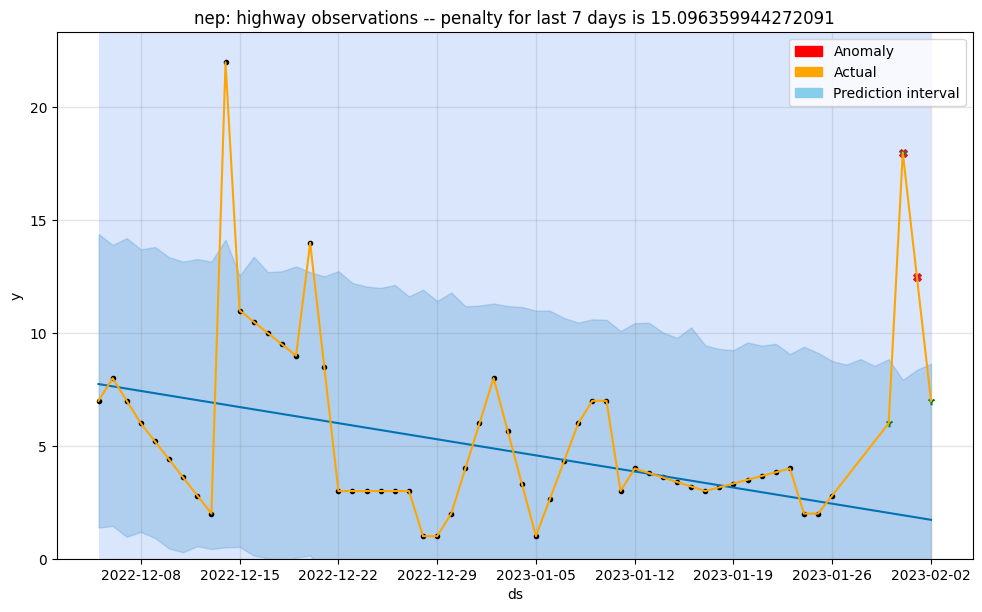

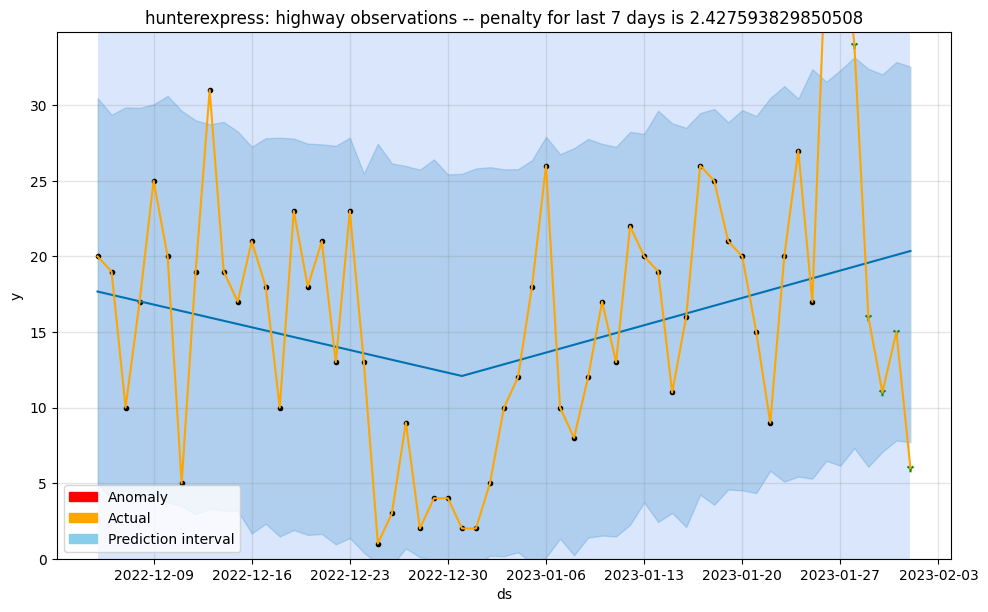

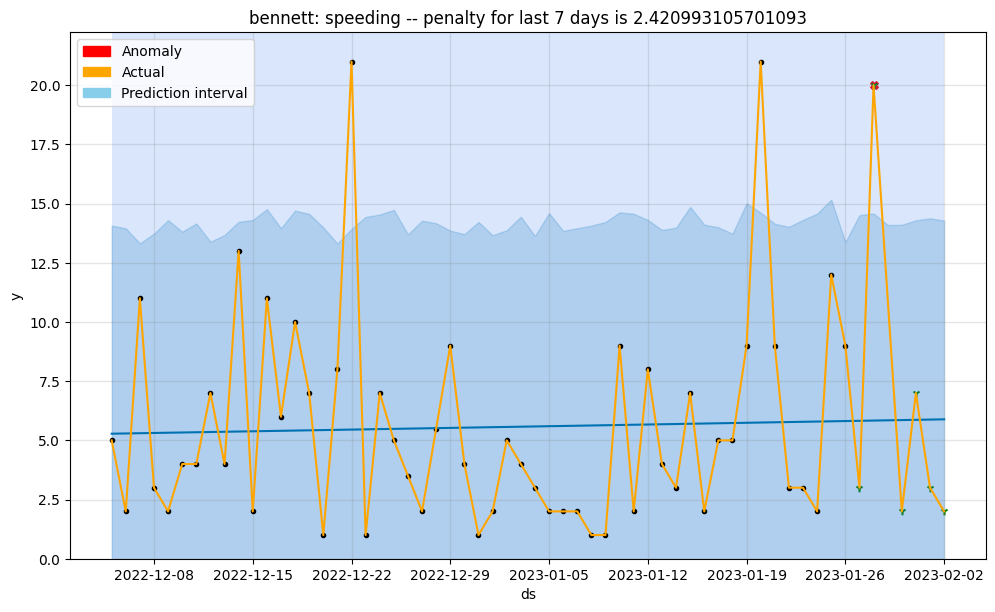

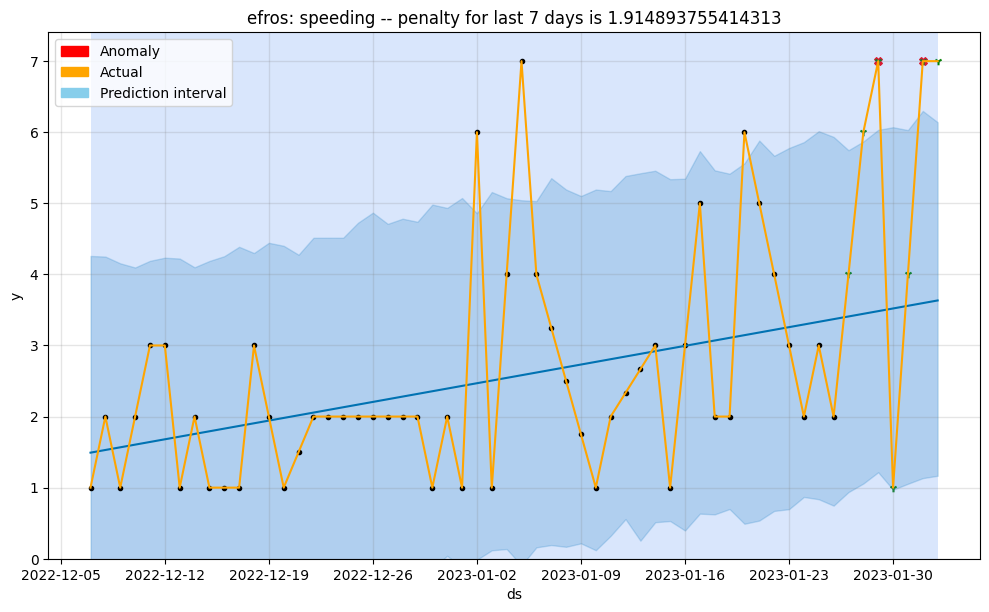

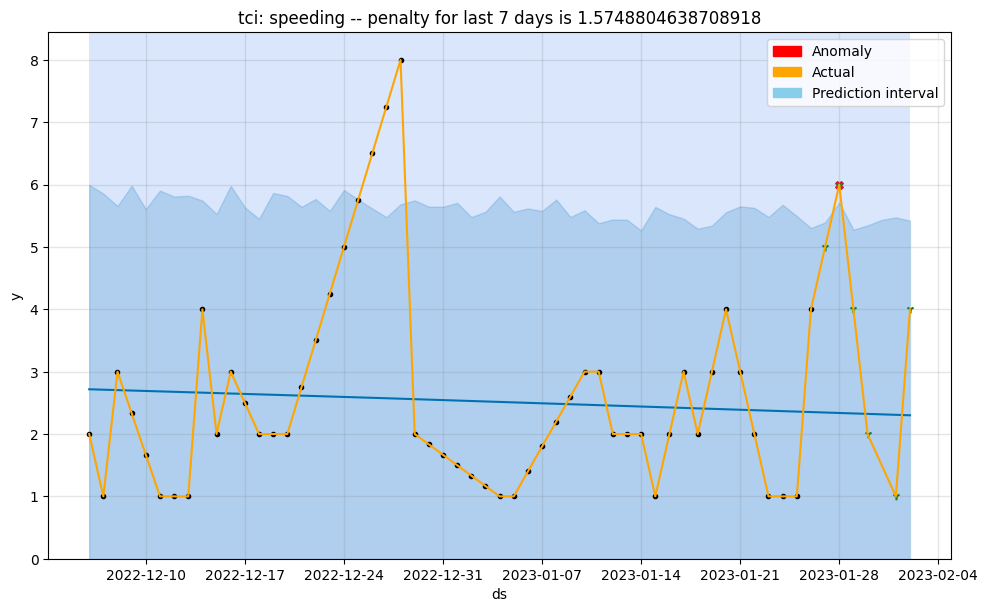

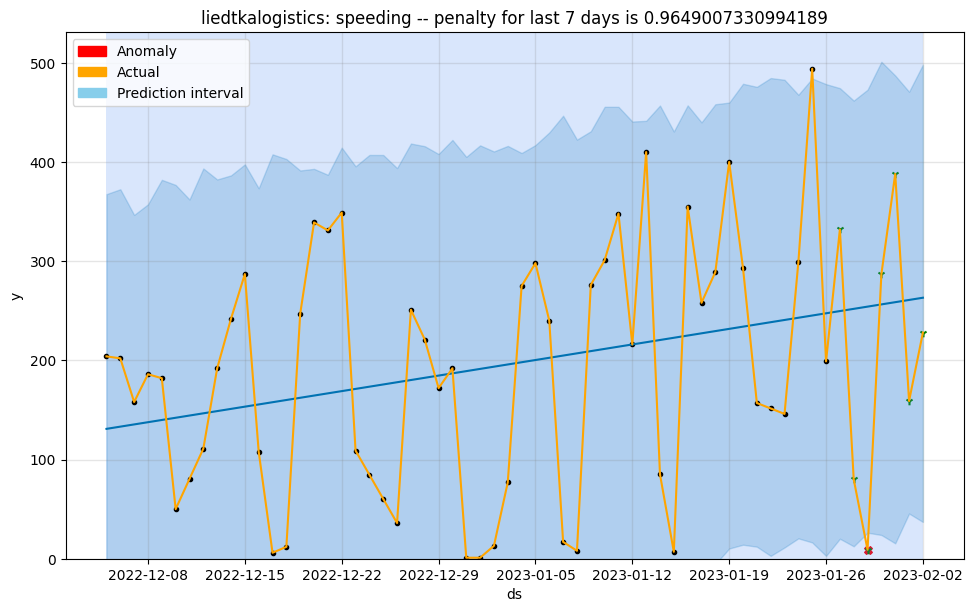

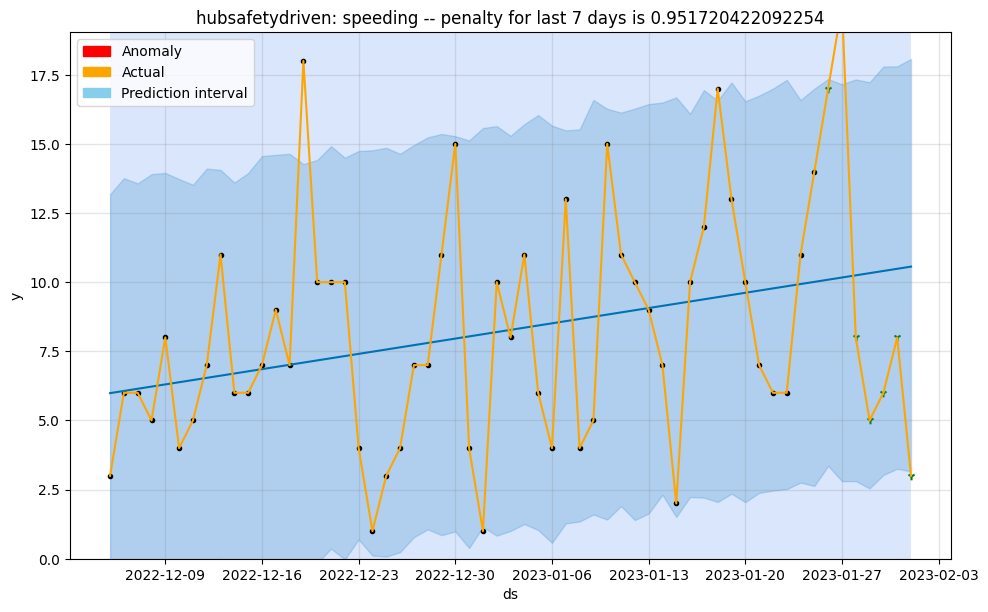

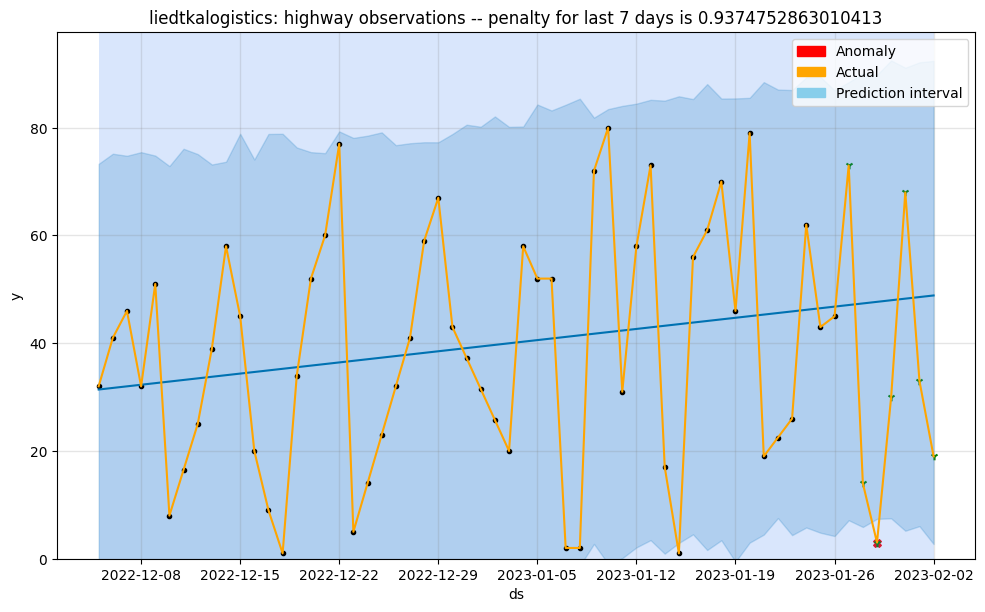

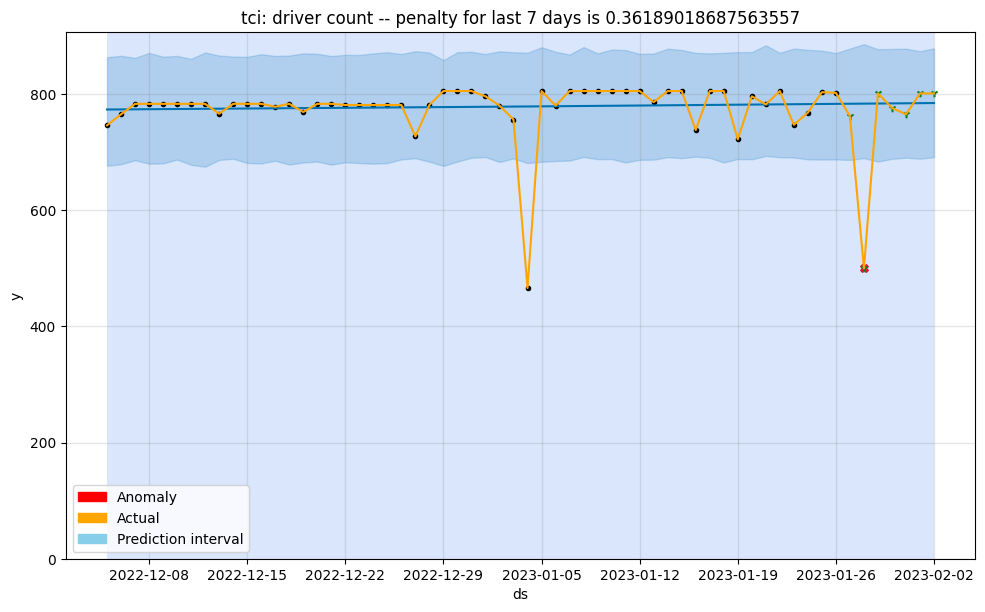

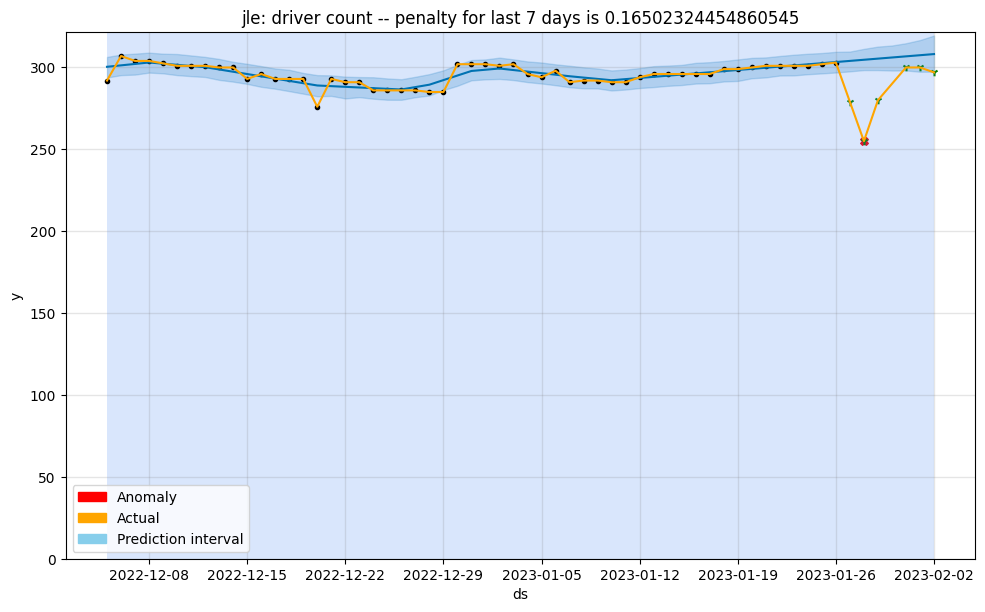

In [ ]:
for ad in results:
    if ad.data.P >0:#to filter out zero penalty series from plotting
        prophet_plot(ad, post_to_slack=False)

In [ ]:
#https://github.com/idelic-inc/data-science/blob/db/ds/data_science/v4/server.py

